# Practical Proportional (P) and Proportional-Integral (PI) Control

## Learning Goals

* Explain terms in the equations for proportional control and proportional-integral control/
* Derive velocity from form of PI control.
* Define terminology
    * negative feedback
    * bias (aka offset or null) term
    * proportional gain and integral gain
* Explain difference between setpoint tracking and disturbance rejection.
* Explain roles of the proportional and integral terms contribute.
* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * Control algorithm modifications
         * Event loop modifications
    * Bumpless Transfer

## Negative Feedback

**Negative feedback** is the core principle underpinning process control.  Negative feedback suppresses deviations from the setpoint. If the process variable grows above the setpoint then the manipulated variable is decreased. If the process variable falls below the setpoint then the manipulated variable is increased.

If the system exhibits a negative-going response to a positive change in the manipulated variable, then the sign of the proportional gain must be negative to assure negative feedback control.

**Positive feedback** is encountered in social, economic, and biological systems where there is a desire to amplify a desirable outcome. Positive feedback can induce good behaviors, result in 'virtuous' cycles of innovation and development, or wealth creation. But in most hard engineering situations, the immediate objective is to cause a variable to track a setpoint for which negative feedback is enabling technology

<hr>

**Study Question:** Describe the two types of negative feedback taking place in the glucose/insulin/glucagon system diagrammed below. 

![](http://4.bp.blogspot.com/-ZKMZhvwDJ2o/UM3-y4BDIqI/AAAAAAAAAbM/PIsa1XpziNg/s1600/fbl+glucose.gif)


**Study Question:** Why are two feedback loops necessary in this biological system? Can you think of an analogy for temperature control of the Temperature Control Lab?

**Study Question:** For the glucose feedback loops diagrammed above, describe at least one physiological source disturbance for each.

**Study Question:** Describe a situation where you have witnessed positive feedback in an audio or visual system.

<hr>

## Nomenclature

In this notebook we will refer to control signals with a generic nomenclature common to the process control industry.

![](./figures/FeedbackControlDiagram.png)

* **CV**: Control variables. A variable that is the subject of control. For example, a product composition.
* **PV**: Process variables. A variable that can be measured. Sometimes the same as the control variable, often different but closely related to a CV.  For example, pressure or temperature of a binary mixture at phase equilibrium may be a proxy for composition.
* **MV**: Manipulated variables. Variables that can be manipulated by the control system, such as flow via a valve position, or power input to heater.
* **DV**: Disturbance variables. All of the exogeneous inputs that can affect our system of interest.
* **SP**: Setpoints. Desired values for the control variables.

## Typical P&ID Diagram for PI and PID control.

![](https://cdn.instrumentationtools.com/wp-content/uploads/2020/01/Identify-Process-Variables-in-PID.png)

## Time-Out for Engineering History

Proportional control, and its variations, have a long history of implementation in both ancient and modern technologies.

### Origins of PID Control

#### Boulton and Watt Steam Engine

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/SteamEngine_Boulton%26Watt_1784.png/1280px-SteamEngine_Boulton%26Watt_1784.png)

[Video demonstrating how a mechanical governor works.](https://youtu.be/B01LgS8S5C8?t=42)

#### Ship Autopilot - First PID application

![](https://owaysonline.com/wp-content/uploads/Block-Diagram-of-Ships-Auto-Pilot.png)

### Implementations

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Nozzle_and_flapper_proportional_controller.png/1280px-Nozzle_and_flapper_proportional_controller.png)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Smart_current_loop_positioner.png/1024px-Smart_current_loop_positioner.png?1645118511583)

A collection of [PID controllers you can buy on Amazon](https://www.amazon.com/pid-controller/s?k=pid+controller) for home and commercial use: 



### Formulation of Proportional Control

**Proportional control** adjusts the manipulated variable in proportion to the error between the setpoint and measured process variable.

$$MV(t) = \bar{MV} - K_P(PV(t) - SP(t))$$

When measurements and actions take place at discrete points in time

$$\begin{align}
MV_k & = \bar{MV} - K_P(PV_k - SP_k)
\end{align}$$

The constant of proportionality, $K_p$, is called the **proportional control gain**. The **error signal** is the difference between the the measured process variable and setpoint,

$$\begin{align}
e_k & = PV_k - SP_k
\end{align}$$

for which the proportional control becomes

$$\begin{align}
MV_k & = \bar{MV} - K_P e_k
\end{align}$$

The negative sign results in **negative feedback control**. 

The constant term $\bar{MV}$ is called the **bias**, **offset**, or **null** value of the manipulated variable. It is an initial estimate of the value of the manipulated variable required to maintain the desired setpoint. The estimate can be determined in several ways:

* manual adjustment of the manipulated variable followed by a transition to automatic control,
* solving a process model for the desired steady state,
* feedforward control,
* a user provided estimate,
* set to zero.

In subsequent notebooks we will see how $\bar{MV}$ is used when building advanced control implementations.

### Proportional Control Implementation

Using the Python `yield` statement, n instance of a proportional controller is created by specifying the gain $K_P$, upper and lower bounds on the manipulated variable, and the offset value $\bar{MV}$.

In [ ]:
# proportional control
def P(Kp, MV_bar=0):
    
    # initialize MV ... must do this so the first use returns a useful value
    MV = MV_bar
    
    # run indefinitely
    while True:
        
        # yield MV to calling program. Then pause and wait for updates to SP aand PV
        SP, PV = yield MV
        
        # compute error signal
        e = PV - SP
        
        # compute new value of the manipulated variable
        MV = MV_bar - Kp*e
        
        # limit the manipulated variable to the feasible range of values
        MV = max(0, min(100, MV))


The benefits of using the `yield` statement is that we can use the same code to create multiple instances of controller, each with it's own parameters and state. The communication between the main event loop and a controller instance is illustrated in this diagram:

![](https://jckantor.github.io/cbe30338-2021/figures/controller-coroutine.png)

The following cells demonstrate performance of the controller when subject to a step change in setpoint and a disturbance input.

### Testing Setpoint and Disturbance Reponses

We'll test the controller using the following inputs:

* At time 20, the setpoint will switch from 25C to 40C.
* At time 200, the second heater will turn at 100% power to introduce a disturbance.

Let's see how proportional control works when applied to the Temperature Control Laboratory. For this simulation we set $\bar{MV} = 0$ and $K_p = 3.0$.

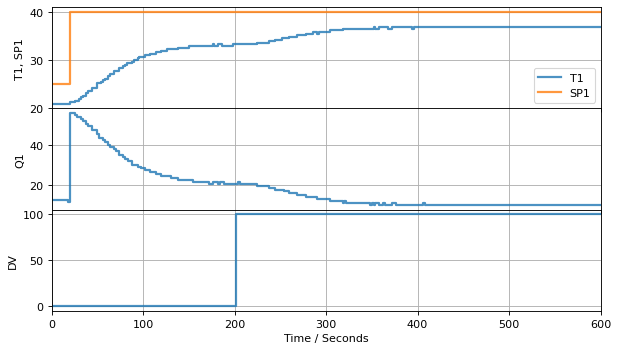

TCLab Model disconnected successfully.


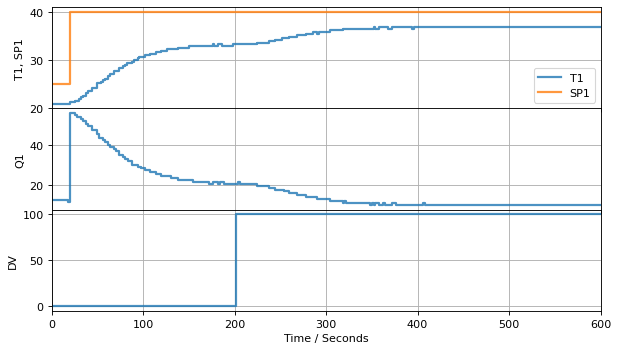

In [ ]:
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=10)

# create functions to simulate setpoints and disturbance variables
def SP(t):
    return 40 if t >= 20 else 25

def DV(t):
    return 100 if t >= 200 else 0

# create a controller instance
controller = P(3)

# simulation duration and sampling time
t_final = 600
t_step = 2

with TCLab() as lab:

    # intialize historian and plotting
    sources = [["T1", lambda: lab.T1],
               ["SP1", lambda: SP(t)],
               ["Q1", lab.Q1],
               ["DV", lambda: DV(t)]]
    h = Historian(sources)
    p = Plotter(h, t_final, layout=[["T1", "SP1"], ["Q1"], ["DV"]])
    
    # initialize maximum power for both heaters
    lab.P1 = 200
    lab.P2 = 200
    
    # initialize the controller
    U1 = next(controller)
    lab.Q1(U1)
    lab.Q2(DV(0))

    # event loop
    for t in clock(t_final, t_step):
        
        # get measurement of process variable T1
        T1 = lab.T1
        
        # send current setpoint and PV to controller
        U1 = controller.send((SP(t), T1))
        
        # update manipulated variable
        lab.Q1(U1)
        
        # simulate disturbance
        lab.Q2(DV(t))
        
        # update the historian
        p.update(t)

For systems without significant time delay and with properly chosen parameters, proportional control can achieve a fast response to changes in setpoint. Note, however, the steady state may be different than the desired setpoint, sometimes unacceptably different. This steady-state error a short-coming of purely proportional control.

<hr>

**Study Question:** For this simulation, did the proportional control achieve the setpoint? Did proportional control reject the disturbance? How serious is the problem?

<hr>

### Steady-State Offset

Proportional-only control provides no assurance the the process variable will eventually acquire the setpoint. To see this, consider the proportional control law

$$MV_k = \bar{MV} - K_P e_k$$

in the limit $k\rightarrow\infty$. 

$$e_{\infty} = \frac{\bar{MV} - MV_{\infty}}{K_P}$$

The error $e_\infty$ expresses the steady-state difference between a process variable and it setpoint. With proportional control, the only options to reduce steady-state offset are 

1. Increase $K_P$. This leads to increasing oscillations and relay-like behavior of the manipulated variable.
2. Find a perfect initial estimate for $\bar{MV}$. If we could do this, we wouldn't need feedback control.

**A persistent steady-state offset is most significant shortcoming of proportional-only control.**

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

## Proportional-Integral (PI) Control

### Position form

Given a process variable $PV$ and setpoint $SP$, proportional-integral control is defined by the relation

\begin{align}
MV(t) & = \bar{MV} - K_P\left(PV(t) - SP(t)\right) - K_I\int_{-\infty}^t (PV(t') - SP(t'))\,dt'
\end{align}

or 

\begin{align}
MV(t) & = \bar{MV} - K_P e(t) - K_I\int_{-\infty}^t e(t') \,dt'
\end{align}

where

$$e(t) = PV(t) - SP(t)$$

where **$K_P$ is the proportional gain** and **$K_I$ is the integral gain**. When implemented in discrete time with time steps of length $h$, the basic rule for proportional-integral control becomes

\begin{align}
MV_k & = \bar{MV} - K_P(PV_k - SP_k) - h K_I\sum_{j=0}^{j=k}(PV_j - SP_j)
\end{align}

or 

\begin{align}
MV_k & = \bar{MV} - K_P e_k - h K_I\sum_{j=0}^{j=k}e_j
\end{align}

where

\begin{align}
e_k & = PV_k - SP_k
\end{align}

This is the so-called **position form** of PI control. The position form specifies the value (or "position") of the manipulated variable stricly in terms of the current and past values of the **error** signal $e_k$. Note the sign convention: A positive error occurs when the process variable is greater than the setpoint. The position form of PI control is rarely used in practice.

### Velocity form

A more common implementation of PI control is done by computing how much the manipulated variable changes at each time step, and incrementing the manipulated variable by that amount. Consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} - K_p e_{k-1} - h K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} - K_p e_{k} - h K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a formula for updating the value of $MV$ in response to process measurements or changes in setpoint.

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

with $MV_0 = \bar{MV}$. Let's see how this works.

In [20]:
def PI(Kp, Ki, MV_bar=0):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV = MV - Kp*(e - e_prev) - t_step*Ki*e
        MV = max(0, min(100, MV))
        e_prev = e
        

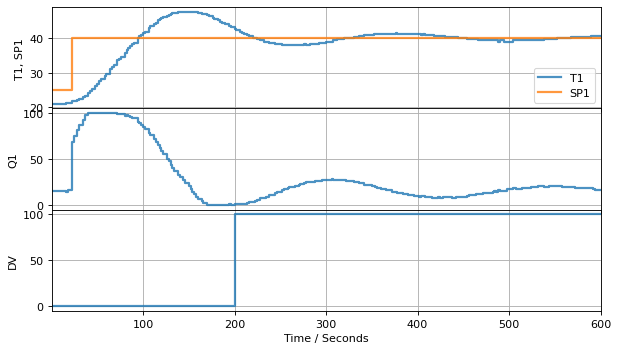

TCLab Model disconnected successfully.


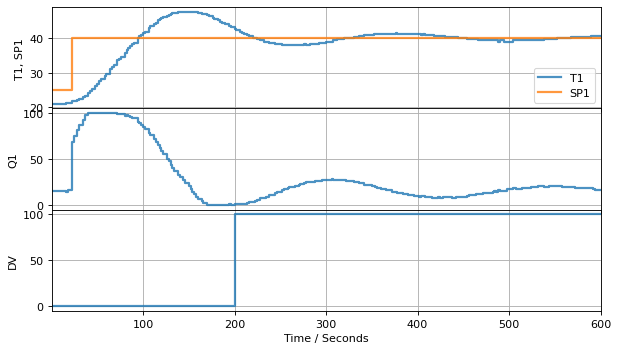

In [21]:
from tclab import TCLab, clock, Historian, Plotter, setup
TCLab = setup(connected=False, speedup=60)

def SP(t):
    return 40 if t >= 20 else 25

def DV(t):
    return 100 if t>= 200 else 0

controller = PI(3, 0.2)

t_final = 600
t_step = 2

with TCLab() as lab:
    sources = [("T1", lambda: lab.T1),
               ("Q1", lab.Q1),
               ("DV", lab.Q2),
               ("SP1", lambda: SP(t))]
    h = Historian(sources)
    layout = [["T1", "SP1"], ["Q1"], ["DV"]]
    p = Plotter(h, t_final, layout=layout)
    
    # initialize manipulated variable
    lab.P1 = 200
    lab.P2 = 200
    
    U1 = next(controller)
    lab.Q1(U1)

    # event loop
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send((SP(t), T1))
        lab.Q1(U1)
        lab.Q2(DV(t))
        p.update(t)    

As we can see from this example, an important practical property of proportonal-integral control is **steady-state tracking of the setpoint.** In other words, for a steaady setpoint $\bar{SP}$, at steady-state 

\begin{align}
\lim_{k \rightarrow \infty} PV_k = \bar{SP}
\end{align}

To see why this is true, start with the velocity form of the proportional-integral controller

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

At steady-state $MV_{k} = MV_{k-1}$ and $e_{k} = e_{k-1}$ leaving 

$$h K_i e_{k} = 0 \implies e_{k} = 0 \implies PV_{k} = \bar{SP}$$

Steady-state tracking is normally important in chemical process applications. For this reason, PI control is, by far, the most commonly encountered control used in the process industries.

<hr>

**Study Question:** Repeat the simulation experiments using the Ziegler-Nichols and the Astrom and Murray tuning rules for PI control. Compare the magnitude of the recommended control constants. Compare the resulting performance in response to regard to both setpoint tracking and disturbance rejection. Compare:

* Maximum overshoot
* Damping
* Time to acheive steady-state

<hr>